In [1]:
import pandas as pd #for data handling
pd.options.display.max_rows = 999 #set the max no of rows you can see. 
pd.set_option('display.max_columns', 999) #another way to do the same thing

import seaborn as sns 
import numpy as np #for matrix operation
import matplotlib.pyplot as plt 

## Read all the datasets 

In [2]:
ping_df=pd.read_csv('DS TakeHome Assignment/data/pings.csv')
driver_df=pd.read_csv('DS TakeHome Assignment/data/drivers.csv')
test_df=pd.read_csv('DS TakeHome Assignment/data/test.csv')

# Exploratory Data Analysis

In [3]:
ping_df.head()

,driver_id,ping_timestamp
0,899313,1496278800
1,373017,1496278800
2,798984,1496278800
3,245966,1496278800
4,689783,1496278800


In [4]:
len(ping_df.driver_id.unique()) ## Number of unique drivers

2480

In [5]:
ping_df.isnull().sum().sum()  ## This gives that there are no missing value in ping data

0

In [6]:
ping_df.shape ## number of rows and columns in ping_df

(50528701, 2)

In [7]:
ping_df.drop_duplicates(inplace=True) ## Only keep the unique rows in the dataframe

In [8]:
ping_df.shape ## Now after removing duplicate rows number of rows and columns in ping_df

(50489158, 2)

###  Add a date variable i.e. convert unix timestamp to date

In [9]:
ping_df['datetime'] = pd.to_datetime(ping_df['ping_timestamp'],unit='s') ### Converting to datetime

In [10]:
ping_df['date']=ping_df['datetime'].dt.date  ### Adding a variable date

In [11]:
ping_df.sample(5)

,driver_id,ping_timestamp,datetime,date
45685291,569948,1497930360,2017-06-20 03:46:00,2017-06-20
30831748,854245,1497383205,2017-06-13 19:46:45,2017-06-13
15611850,635091,1496825025,2017-06-07 08:43:45,2017-06-07
27060059,266860,1497252600,2017-06-12 07:30:00,2017-06-12
10806515,428009,1496661645,2017-06-05 11:20:45,2017-06-05


## We will now create our target variable i.e. online hours of a driver from this ping dataset. As we are getting pings every 15 seconds, we will assume every ping says that driver was online for 15 seconds.

### We will group by driver id and the date and get the count of pings, and then multiply the count with 15/3600 so that we get the number of hours the driver was online

In [12]:
ping_counts_df = ping_df.groupby(['driver_id', 'date']).size().reset_index(name='counts')

In [13]:
ping_counts_df.sample(5)

,driver_id,date,counts
14624,420312,2017-06-15,1070
27570,706821,2017-06-21,826
12363,377052,2017-06-14,2057
38559,936332,2017-06-13,137
275,118193,2017-06-21,741


In [14]:
ping_counts_df.columns

Index(['driver_id', 'date', 'counts'], dtype='object')

In [15]:
del ping_df ## Deleting the ping dataframe to free space

In [16]:
ping_counts_df['counts'].sum() ## Just to check if we got the counts right

50489158

In [17]:
ping_counts_df['counts'] = ping_counts_df['counts']*15/3600 ## Converting into hours 

In [18]:
ping_counts_df['counts'].sum()  ## Checking it again

210371.49166666667

In [19]:
50489158*15/3600

210371.49166666667

In [20]:
ping_counts_df.rename(columns={'counts': 'online_hours'}, inplace=True)

In [21]:
ping_counts_df.head()

,driver_id,date,online_hours
0,111556,2017-06-01,2.016667
1,111556,2017-06-02,2.266667
2,111556,2017-06-05,4.229167
3,111556,2017-06-06,2.775000
4,111556,2017-06-07,2.383333


## Deriving  month and day variables so that we have some x features (as actual date and datetime can't be used for prediction because the test data won't have the same dates )

In [22]:
ping_counts_df['date'] = pd.to_datetime(ping_counts_df['date'])

In [23]:
ping_counts_df['dom']=ping_counts_df['date'].dt.day  ### Adding a variable day of month

In [24]:
day_of_week={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

In [25]:
ping_counts_df['dow']=ping_counts_df['date'].dt.dayofweek.map(day_of_week)  ### Adding a variable day of the week

In [26]:
ping_counts_df['month']=ping_counts_df['date'].dt.month  ### Adding a variable month of the year

In [27]:
ping_counts_df.sample(5)

,driver_id,date,online_hours,dom,dow,month
38078,929138,2017-06-07,1.820833,7,Wednesday,6
26583,682795,2017-06-01,7.766667,1,Thursday,6
28564,730697,2017-06-20,0.662500,20,Tuesday,6
39006,946120,2017-06-15,0.987500,15,Thursday,6
18043,500500,2017-06-12,1.612500,12,Monday,6


In [28]:
ping_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41676 entries, 0 to 41675
Data columns (total 6 columns):
driver_id       41676 non-null int64
date            41676 non-null datetime64[ns]
online_hours    41676 non-null float64
dom             41676 non-null int64
dow             41676 non-null object
month           41676 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.9+ MB


In [29]:
ping_counts_df.drop('date', axis=1, inplace=True )

##  Now we will convert the day of week to int for modeling, we will convert every weekday as new variable and binary value will be inserted. This can be done by the below get_dummies function. We will remove first day because that will create colinearity (As sum of all will be 1 in that case) 

In [30]:
dummy = pd.get_dummies(ping_counts_df['dow'], prefix = 'dow', drop_first = True)

In [31]:
ping_counts_df = pd.concat([ping_counts_df, dummy], axis = 1)
ping_counts_df.drop('dow', axis=1, inplace=True)

In [32]:
ping_counts_df.sample(5)

,driver_id,online_hours,dom,month,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
19508,533503,6.400000,5,6,1,0,0,0,0,0
378,120644,8.737500,6,6,0,0,0,0,1,0
40438,976598,6.666667,15,6,0,0,0,1,0,0
27574,707041,2.170833,7,6,0,0,0,0,0,1
10558,343976,7.312500,3,6,0,1,0,0,0,0


## Now looking at the drivers profile

In [33]:
driver_df.sample(5)

,driver_id,gender,age,number_of_kids
1967,499610,MALE,31,2
2411,166945,FEMALE,18,1
752,113140,MALE,18,0
82,164378,MALE,30,0
826,979669,MALE,67,0


In [34]:
driver_df.describe()

,driver_id,age,number_of_kids
count,2500.000000,2500.000000,2500.000000
mean,562397.047200,35.922400,1.395200
std,256410.208166,14.171207,1.505697
min,111556.000000,18.000000,0.000000
25%,343199.000000,25.000000,0.000000
50%,563854.500000,31.000000,1.000000
75%,787978.750000,45.000000,3.000000
max,998740.000000,75.000000,4.000000


### Above we can see that age lies between 18 and 75 and number of kids lie between 0 and 4, so logically there are no outliers in these columns

In [35]:
driver_df.gender.value_counts()

MALE      1894
FEMALE     606
Name: gender, dtype: int64

In [36]:
driver_df.isnull().sum().sum()  ## This gives that there are no missing value in driver data

0

Text(0.5, 1.0, 'Female')

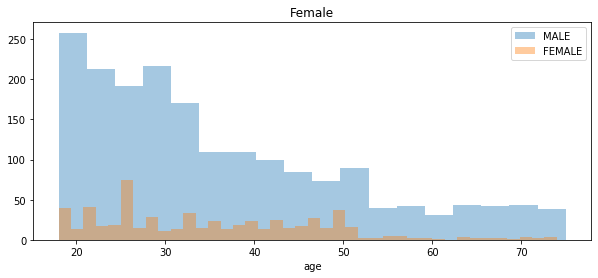

In [37]:
male = 'MALE'
female = 'FEMALE'
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10, 4))
ax = sns.distplot(driver_df[driver_df['gender']=='MALE'].age, bins=18, label = male, ax = axes, kde =False)
ax = sns.distplot(driver_df[driver_df['gender']=='FEMALE'].age, bins=40, label = female, ax = axes, kde =False)
ax.legend()
ax.set_title('Female')

In [38]:
driver_df.shape ## Number of rows and columns of driver profiles

(2500, 4)

In [39]:
driver_df.drop_duplicates(inplace=True)  ## Remove any duplicate rows from driver df

In [40]:
driver_df.shape ### Number of rows and columns of unique driver profiles

(2500, 4)

In [41]:
len(driver_df.driver_id.unique()) ## Number of unique driver ids

2497

### Above shows that there are 2497 unique ids and 2500 rows of unique profiles, that means there are 3 duplicate driver ids, Let's find them

In [42]:
driver_df[driver_df.duplicated(['driver_id'], keep=False)]

,driver_id,gender,age,number_of_kids
231,320227,MALE,22,4
388,320227,MALE,42,4
1311,799250,FEMALE,27,4
1550,800600,FEMALE,22,0
1765,799250,FEMALE,23,0
2008,800600,FEMALE,28,1


## We will assume that the latest entry of a driver would be legit one, so we are taking the last row of each unique driver_ids

In [43]:
driver_df.drop_duplicates(subset='driver_id', keep="last", inplace=True) 

In [44]:
driver_df.shape

(2497, 4)

### Converting gender object to int object just like we did for weekday

In [45]:
gender_dummy = pd.get_dummies(driver_df['gender'], prefix = 'gender', drop_first = True)

In [46]:
driver_df = pd.concat([driver_df, gender_dummy], axis = 1)
driver_df.drop('gender', axis=1, inplace=True)

In [47]:
driver_df.sample(5)

,driver_id,age,number_of_kids,gender_MALE
2381,889973,21,0,1
2326,937323,37,0,1
2073,406972,47,0,1
673,578761,46,0,1
1171,706297,27,0,1


## Now, to create a train dataset, we will join the driver df and ping count df

In [48]:
train_df = pd.merge(ping_counts_df,driver_df, on = 'driver_id' )

In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41676 entries, 0 to 41675
Data columns (total 13 columns):
driver_id         41676 non-null int64
online_hours      41676 non-null float64
dom               41676 non-null int64
month             41676 non-null int64
dow_Monday        41676 non-null uint8
dow_Saturday      41676 non-null uint8
dow_Sunday        41676 non-null uint8
dow_Thursday      41676 non-null uint8
dow_Tuesday       41676 non-null uint8
dow_Wednesday     41676 non-null uint8
age               41676 non-null int64
number_of_kids    41676 non-null int64
gender_MALE       41676 non-null uint8
dtypes: float64(1), int64(5), uint8(7)
memory usage: 2.5 MB


In [50]:
train_df.sample(5)

,driver_id,online_hours,dom,month,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,age,number_of_kids,gender_MALE
16097,459646,2.579167,7,6,0,0,0,0,0,1,31,2,1
2600,173853,3.000000,20,6,0,0,0,0,1,0,18,0,1
18018,500365,7.725000,1,6,0,0,0,1,0,0,48,1,1
32054,800600,8.029167,9,6,0,0,0,0,0,0,28,1,0
23463,618651,8.579167,6,6,0,0,0,0,1,0,37,0,1


/Users/keshav.somani/.py_venv/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/keshav.somani/.py_venv/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


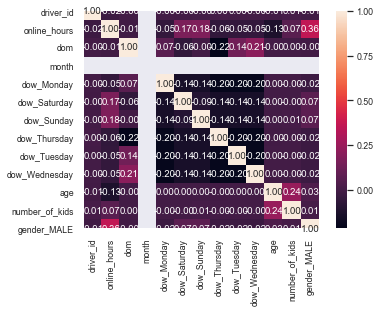

In [51]:
correlation_map = np.corrcoef(train_df.values.T)
sns.set(font_scale=0.8)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=train_df.columns, xticklabels=train_df.columns)

plt.show()

### Above shows that there are no high correlation between the x variables

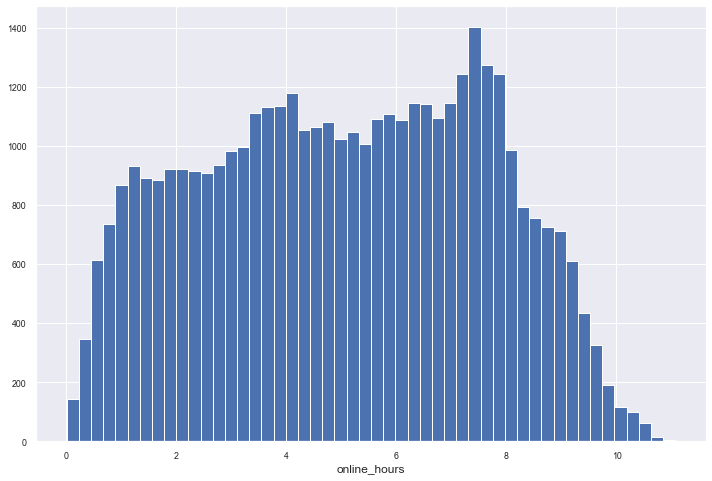

In [52]:
plt.figure(figsize=(12,8))
plt.hist(train_df.online_hours.values, bins=50)
plt.xlabel('online_hours', fontsize=12)
plt.show()

### Above shows the histogram of online hours

## Creating the test data with the same schema as train

In [53]:
test_df.sample(5)

,driver_id,date,online_hours
4433,783794,2017-6-26,7
12013,851570,2017-6-27,3
9161,679486,2017-6-23,8
2342,861371,2017-6-24,0
13150,808404,2017-6-24,0


In [54]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 3 columns):
driver_id       17500 non-null int64
date            17500 non-null object
online_hours    17500 non-null int64
dtypes: int64(2), object(1)
memory usage: 410.3+ KB


In [55]:
test_df['dom'] = pd.to_datetime(test_df['date']).dt.day

In [56]:
test_df['month'] = pd.to_datetime(test_df['date']).dt.month

In [57]:
test_df['dow']=pd.to_datetime(test_df['date']).dt.dayofweek.map(day_of_week)  ### Adding a variable day of the week

In [58]:
test_df.sample(5)

,driver_id,date,online_hours,dom,month,dow
9194,763165,2017-6-25,0,25,6,Sunday
12308,885564,2017-6-26,1,26,6,Monday
8488,838618,2017-6-24,7,24,6,Saturday
818,191846,2017-6-22,4,22,6,Thursday
12109,980578,2017-6-22,9,22,6,Thursday


In [59]:
test_dummy = pd.get_dummies(test_df['dow'], prefix = 'dow', drop_first = True)
test_df = pd.concat([test_df, test_dummy], axis = 1)
test_df.drop('dow', axis=1, inplace=True)

In [60]:
test_df.head()

,driver_id,date,online_hours,dom,month,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,979863,2017-6-28,7,28,6,0,0,0,0,0,1
1,979863,2017-6-27,9,27,6,0,0,0,0,1,0
2,979863,2017-6-26,9,26,6,1,0,0,0,0,0
3,979863,2017-6-25,10,25,6,0,0,1,0,0,0
4,979863,2017-6-24,9,24,6,0,1,0,0,0,0


In [61]:
test_df = pd.merge(test_df, driver_df, on = 'driver_id')

In [62]:
test_df.drop('date', axis=1, inplace=True)

In [63]:
test_df.head()

,driver_id,online_hours,dom,month,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,age,number_of_kids,gender_MALE
0,979863,7,28,6,0,0,0,0,0,1,26,2,1
1,979863,9,27,6,0,0,0,0,1,0,26,2,1
2,979863,9,26,6,1,0,0,0,0,0,26,2,1
3,979863,10,25,6,0,0,1,0,0,0,26,2,1
4,979863,9,24,6,0,1,0,0,0,0,26,2,1


In [64]:
test_df.columns, train_df.columns ## Checking the columns are similar

(Index(['driver_id', 'online_hours', 'dom', 'month', 'dow_Monday',
        'dow_Saturday', 'dow_Sunday', 'dow_Thursday', 'dow_Tuesday',
        'dow_Wednesday', 'age', 'number_of_kids', 'gender_MALE'],
       dtype='object'),
 Index(['driver_id', 'online_hours', 'dom', 'month', 'dow_Monday',
        'dow_Saturday', 'dow_Sunday', 'dow_Thursday', 'dow_Tuesday',
        'dow_Wednesday', 'age', 'number_of_kids', 'gender_MALE'],
       dtype='object'))

## Creating Train and test X and Y variable

In [65]:
X_train = train_df
Y_train = X_train['online_hours'].values
X_train = X_train.drop('online_hours', axis = 1).values

In [66]:
X_test = test_df
Y_test = X_test['online_hours'].values
X_test = X_test.drop('online_hours', axis = 1).values

# Modeling

In [67]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [68]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

In [69]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=5)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -5.138062 (0.131067)
ScaledLASSO: -6.463259 (0.187020)
ScaledEN: -6.030071 (0.166924)
ScaledKNN: -6.061834 (0.205751)
ScaledCART: -10.344332 (0.667194)
ScaledGBM: -5.218437 (0.367559)


### It looks like Linear Regression is giving the best results. Gradient Boosting has also given comparable results, lets check using grid search if there are any n_estimator which can give a better result than LR 

In [70]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350]))
model = GradientBoostingRegressor(random_state=5)
kfold = KFold(n_splits=10, random_state=5)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-5.047190 (0.128180) with: {'n_estimators': 50}
-5.200649 (0.339038) with: {'n_estimators': 100}
-5.272864 (0.404570) with: {'n_estimators': 150}
-5.297969 (0.427936) with: {'n_estimators': 200}
-5.321419 (0.451649) with: {'n_estimators': 250}
-5.328768 (0.451421) with: {'n_estimators': 300}
-5.343644 (0.461125) with: {'n_estimators': 350}
Best: -5.047190 using {'n_estimators': 50}


## It can be observed that n_estimators 50 has given better results on GBM and that is better than Linear Regression as well. But we will keep both of the models to test on test data 

In [71]:
from sklearn.metrics import mean_squared_error

## Scaling the datasets train and test

In [72]:
scaler = StandardScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)

# Now scale the test dataset
rescaled_X_test = scaler.transform(X_test)

In [73]:
model_gbm = GradientBoostingRegressor(random_state=5, n_estimators=50)
model_gbm.fit(rescaled_X_train, Y_train)
predictions_gbm = model_gbm.predict(rescaled_X_test)
print (mean_squared_error(Y_test, predictions_gbm))

17.501339324394962


In [74]:
model_lr = LinearRegression()
model_lr.fit(rescaled_X_train, Y_train)
predictions_lr = model_lr.predict(rescaled_X_test)
print (mean_squared_error(Y_test, predictions_lr))

12.175311037762143
